In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.utils.normalizing_functions as norm
import src.models.spatial_metrics_calcium_binarized_base as sm
import src.utils.bootstrapped_estimation as bootstrap

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process

%matplotlib widget


In [2]:
# Initialize loader
dataset = 'kinsky'
loader = LoadData(dataset)

# See what's available
# loader.list_available()
loader.show_jupyter_tree()


Dataset path resolved: /home/apolo/Documents/github_projects/information_metrics/data/kinsky


In [3]:
# Load kinsky session
data = loader.load(mouse_id=3, day=1, session=1)

x_coordinates = data['position']['x'].copy()
y_coordinates = data['position']['y'].copy()
time_vector = data['position']['time'].copy()
sampling_rate = data['sampling_rate']
environment_edges = data['environment_edges']
raw_signal = data['traces']['raw'].copy()
filtered_signal = data['traces']['filtered'].copy()
diff_signal = data['traces']['diff'].copy()
original_binary_signal = data['traces']['binary'].copy()


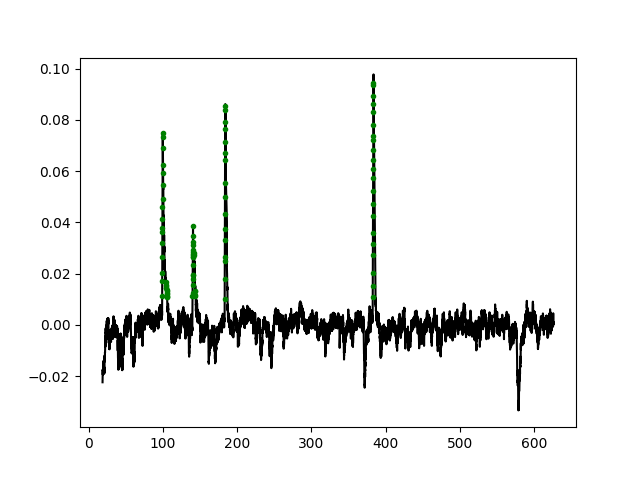

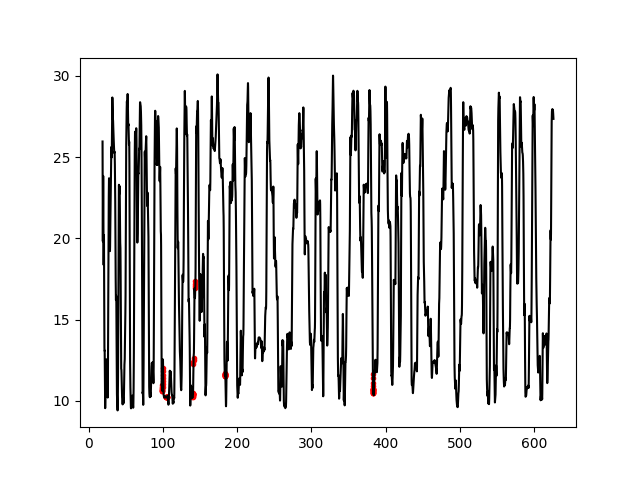

In [4]:
# Cells from fig 2C are 49,127,211,267 from
# data_dir = f"{project_root}/data/Kinsky/Mouse3 - G45/day 1/1 - square/"

# kinksy already provides a binary_signal. 
# But you can define your own using the pre_processing_functions.preprocess_signal

cell = 2
normalized_signal = norm.z_score_norm(raw_signal[cell,:])
signal_type = 'binary'
binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, signal_type, z_threshold = 1)

plt.figure()
plt.plot(time_vector,raw_signal[cell,:],'k')
plt.plot(time_vector[binary_signal==1],raw_signal[cell,:][binary_signal==1],'g.')
plt.show()

plt.figure()
plt.plot(time_vector,x_coordinates,'k',zorder = 5)
plt.plot(time_vector[binary_signal==1],x_coordinates[binary_signal==1],'r.')
plt.show()


In [5]:
# Now define your environment_edges
# You can think of it as a retangular box in cm.
# environment_edges = [[15,50],[35,70]]
environment_edges = [[5,35],[]]

# in cm [[x_min,x_max],[y_min,y_max]]
# If you don`t set it, the program will use min and max coordinates as edges.


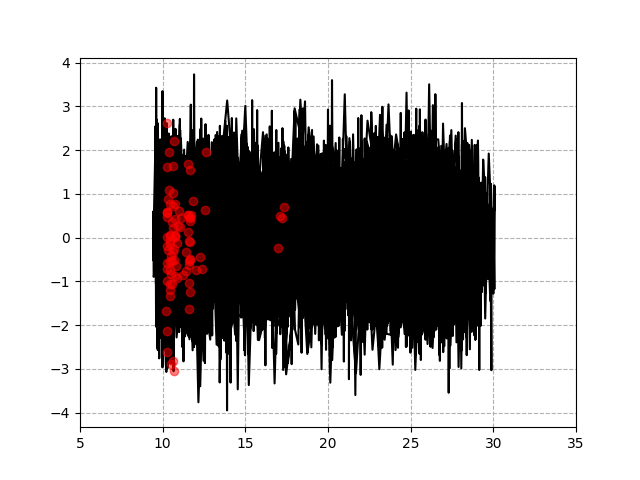

In [6]:
# And test it
x_coordinates_rand = np.random.randn(x_coordinates.shape[0])
plt.figure()
plt.plot(x_coordinates,x_coordinates_rand,'k',zorder = 5)
plt.scatter(x_coordinates[binary_signal==1],x_coordinates_rand[binary_signal==1],color = 'red', alpha=0.5, zorder = 10)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
# plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.grid(ls='--',zorder = 1)
plt.show()


In [7]:
# These parameters were taken from the paper 
# "Hippocampal Place Fields Maintain a Coherent and Flexible Map across Long Timescales"

cell = 49
normalized_signal = norm.z_score_norm(raw_signal[cell,:])
signal_type = 'binary'
binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, signal_type, z_threshold = 1)
binary_signal = original_binary_signal[cell,:].copy()
environment_edges = [[5,35],[15,45]]

# Create a dictionary to hold input parameters for further processing
input_dict = {

# Construct the filename and other identifiers for saving the results
'saving_string' : 'SpatialMetrics.' + signal_type,  # Prefix for the filename
'animal_id' : 'NeuronModel',  # Identifier for the animal or model
'dataset' : 'Simulation',  # Name of the dataset
'day' : 1,  # Day or session number
'neuron' : 1,  # Neuron identifier
'trial' : None,  # Trial identifier (optional, can be None)
'saving_path' : None,  # Directory path for saving results (optional, can be None)
'saving' : False,  # Flag indicating whether to save the results (False means no saving)
'overwrite': False, # Flag indicating whether to overwrite already saved file 
'signal_type' : signal_type, # 'binary' or 'continuous'

# Set inclusion criteria for the analysis
# Kinky used 50 ms minimum occupancy 
'min_time_spent' : 0.05,  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
'min_visits' : 0,  # Minimum number of visits required in each xy bin
'min_speed_threshold' : 1,  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
'speed_smoothing_sigma' : 0.5,  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and information score from map
'x_bin_size' : 1,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size' : 1,  # Size of y bins (in coordinate units [e.g., cm, pixels])
'map_smoothing_sigma_x' : 0.5,  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
'map_smoothing_sigma_y' : 0.5, # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for information calculation
'x_bin_size_info' : 4,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size_info' : 4,  # Size of y bins (in coordinate units [e.g., cm, pixels])

# Set parameters for surrogate analysis
'shift_time' : 200,  # Time shift window in seconds for creating surrogate distributions
'num_cores' : -1,  # Number of CPU cores to use (set to -1 to use all available cores)
'num_surrogates' : 800,  # Number of surrogate distributions to generate

# Set parameters for place fields detection
'min_num_of_bins' : 1,  # Minimum number of xy-bins required to define a place field
'threshold': ('mean_std',1),
'alpha' : 0.05 # alpha on the decision if a cell can be classified as a place cell 
}

y_coordinates = None
signal_data = ProcessData(binary_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(signal_data)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.binary.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


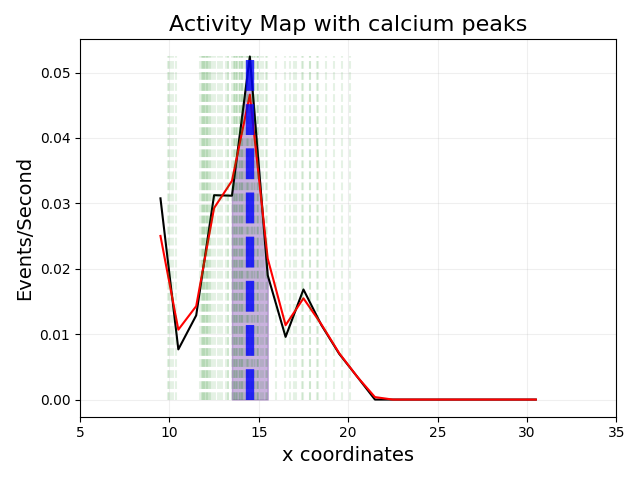

In [47]:

plt.figure()
plt.plot(spatial_metrics_output['x_center_bins'],spatial_metrics_output['activity_map'],color = 'black',label='Raw')
plt.plot(spatial_metrics_output['x_center_bins'],spatial_metrics_output['activity_map_smoothed'],color = 'red',label='Smoothed')

plt.plot([spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_x_location']],[np.nanmin(spatial_metrics_output['activity_map']),np.nanmax(spatial_metrics_output['activity_map'])],color = 'green',linestyle='--',alpha=0.1)
plt.plot([spatial_metrics_output['fields_x_max'],spatial_metrics_output['fields_x_max']],[np.nanmin(spatial_metrics_output['activity_map']),np.nanmax(spatial_metrics_output['activity_map'])],color = 'blue',lw = 6,linestyle='--',alpha=0.8)

bin_size = spatial_metrics_output['input_parameters']['x_bin_size']

for ii in range(1, spatial_metrics_output['num_of_fields'] + 1):
    field_spread = spatial_metrics_output['x_center_bins'][spatial_metrics_output['activity_map_identity'] == ii]
    
    if field_spread.size == 1:
        center = field_spread[0]
        field_spread = np.array([center - bin_size, center + bin_size])
    plt.fill_between(spatial_metrics_output['x_center_bins'],spatial_metrics_output['activity_map'],where = (spatial_metrics_output['x_center_bins'] >= field_spread[0]) & (spatial_metrics_output['x_center_bins'] <= field_spread[-1]),color = 'tab:purple',alpha=0.5)
plt.grid(alpha=0.2)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])

plt.title('Activity Map with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('Events/Second',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.tight_layout()
plt.show()



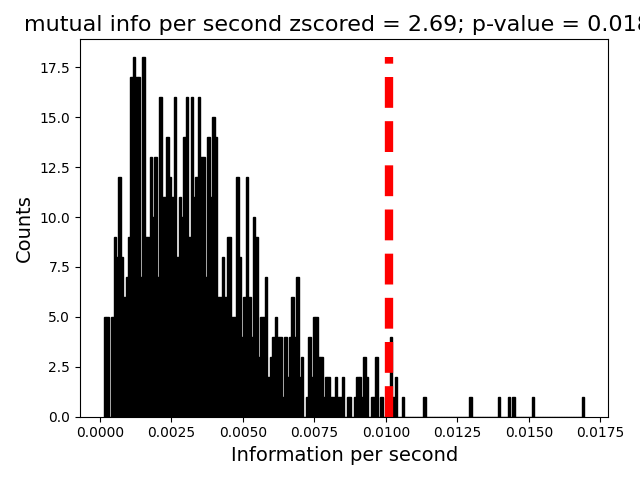

In [48]:

p_value = spatial_metrics_output['mutual_info_per_second_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_second_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_second_original'],spatial_metrics_output['mutual_info_per_second_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per second zscored = {0:.2f}; p-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_second_zscored'],p_value),fontsize=16)
plt.xlabel('Information per second',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


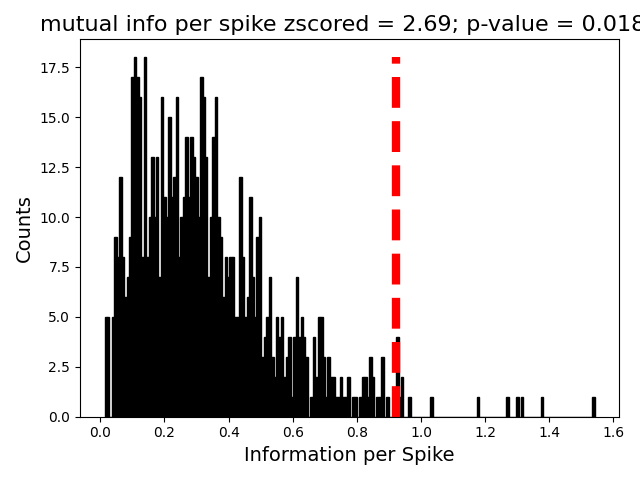

In [49]:

p_value = spatial_metrics_output['mutual_info_per_spike_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_spike_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_spike_original'],spatial_metrics_output['mutual_info_per_spike_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per spike zscored = {0:.2f}; p-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_spike_zscored'],p_value),fontsize=16)
plt.xlabel('Information per Spike',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [51]:
# Place field extension: % relative to the whole enviroment
spatial_metrics_output['place_cell_extension_absolute']


array([0.03333333])

In [52]:
# Place field extension: % relative to enviroment occupancy
spatial_metrics_output['place_cell_extension_relative']


array([0.04545455])

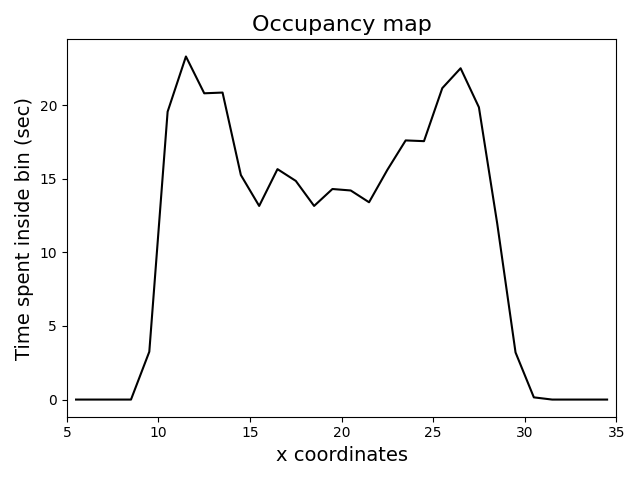

In [57]:

plt.figure()
plt.plot(spatial_metrics_output['x_center_bins'],spatial_metrics_output['timespent_map'],color='black')

plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('Time spent inside bin (sec)',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.tight_layout()
plt.show()


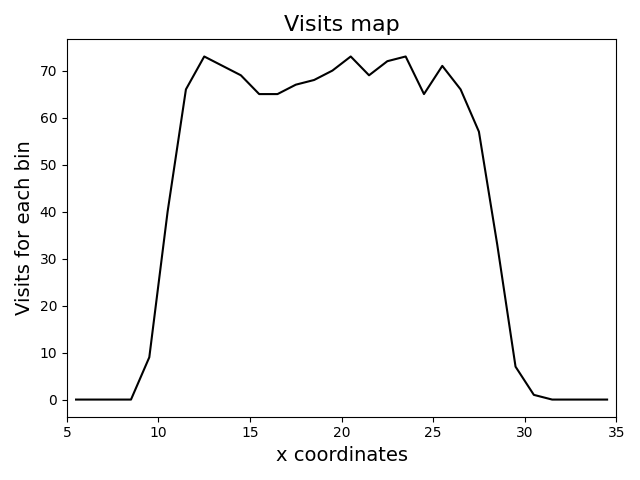

In [58]:

plt.figure()
plt.plot(spatial_metrics_output['x_center_bins'],spatial_metrics_output['visits_map'],color='black')

plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('Visits for each bin',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.tight_layout()
plt.show()



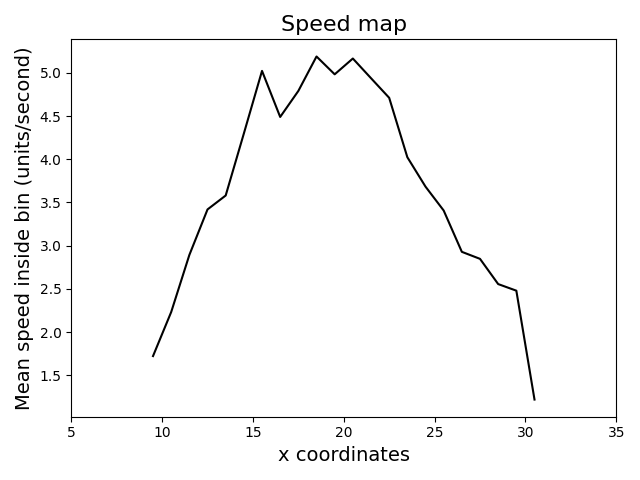

In [59]:

plt.figure()
plt.plot(spatial_metrics_output['x_center_bins'],spatial_metrics_output['speed_map'],color='black')

plt.title('Speed map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('Mean speed inside bin (units/second)',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.tight_layout()
plt.show()
